In [57]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from scipy.stats import norm
import scipy as sp
from scipy.integrate import odeint,quad,simps
from scipy.special import eval_hermite,eval_hermitenorm
from math import sqrt,sin,pi,cos,exp,log,factorial

# Estimation of the operator $\mathcal{L}$

### 0. Data Simulation Euler–Maruyama method
\begin{align}
dX_t &= \sqrt{2D}dW_t \\
X_0 &= 0
\end{align}

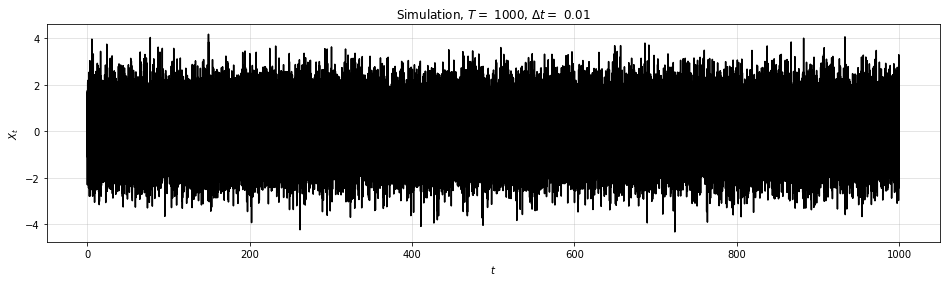

In [58]:
x0 = 0
n = 100000
dt = 0.01
T = dt*n
D = 1
np.random.seed(1)
X = np.random.normal(0,1,n)

_ = plt.figure(figsize=(16,4))
_ = plt.plot(np.linspace(x0,n*dt,n), X,color='black')
_ = plt.grid(alpha=0.4)
_ = plt.xlabel("$t$")
_ = plt.ylabel("$X_t$")
_ = plt.title(f"Simulation, $T=$ {T:.0f}, $\Delta t =$ {dt}")

In [59]:
N = 5000
X_s = X[np.random.choice(range(n),size=N)]

### 1. Compute an estimation of the invariant distribution of $\{x_i\}_{i=1}^{N}$, we denote it by $\hat{\rho}_{\text{eq}}$, we can do it by a non-parametric method such as kernel estimation.

$$p(x) = \frac{1}{\sqrt{2 \pi \beta^{-1}}} \exp\left(- \frac{x^2}{2D} \right)$$
\begin{align}
\end{align}

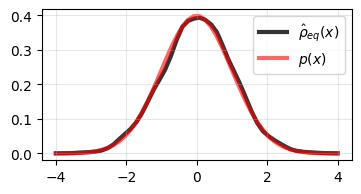

In [60]:
g_kde  = sp.stats.gaussian_kde(X_s)
rho_eq = np.vectorize(lambda x: g_kde(x)[0])
p_invariant = np.vectorize(lambda x: sp.stats.norm.pdf(x,loc=0,scale=np.sqrt(D)))
_ = plt.figure(figsize=(4,2),dpi=100)
_ = plt.plot(np.linspace(-4,4),[rho_eq(x) for x in np.linspace(-4,4)],
             color='black',lw=3,zorder=1,alpha=0.8,label='$\\hat{\\rho}_{eq}(x)$')
_ = plt.plot(np.linspace(-4,4),[p_invariant(x) for x in np.linspace(-4,4)],
             color='r',lw=3,zorder=1,alpha=0.6,label='$p(x)$')
_ = plt.legend()
_ = plt.grid(alpha=0.3,zorder=1)

### 2. Compute an estimate $\rho = \hat{\rho}_{\text{eq}}^{-1/2}$

In [61]:
rho = np.vectorize(lambda x: rho_eq(x)**(-0.5))
Rho = rho(X_s).reshape(1,N)

### 3. Estimate $\epsilon$ computing $T(\epsilon) =\frac{1}{N}\sum_{i,j=1}^N K_\epsilon(x_i,x_j)$ and the derivatives to compute $$\epsilon = \text{argmax}_\epsilon \frac{\log(T(\epsilon + h) - \log(T(\epsilon))}{\log(\epsilon+h) - \log(\epsilon)}$$

In [62]:
Norm = np.zeros((N,N))
for i in range(N):
    Norm[i,:] = -(X_s - X_s[i])**2
Norm /= 4*(Rho.T @ Rho)

In [63]:
h = 1e-6 #Small perturbation for T 
T = lambda epsilon : (1/N**2)*np.exp(Norm / epsilon).sum()
val = []

for l in np.linspace(-20,2): #evaluate for valyes from 2^-30 to 2 
    e = 2**l
    val.append((log(T(h+e)) - log(T(e))) / (log(e+h) - log(e)))

epsilon = 2 **np.linspace(-20,2)[np.argmax(val)]
epsilon

0.0006571778284337678

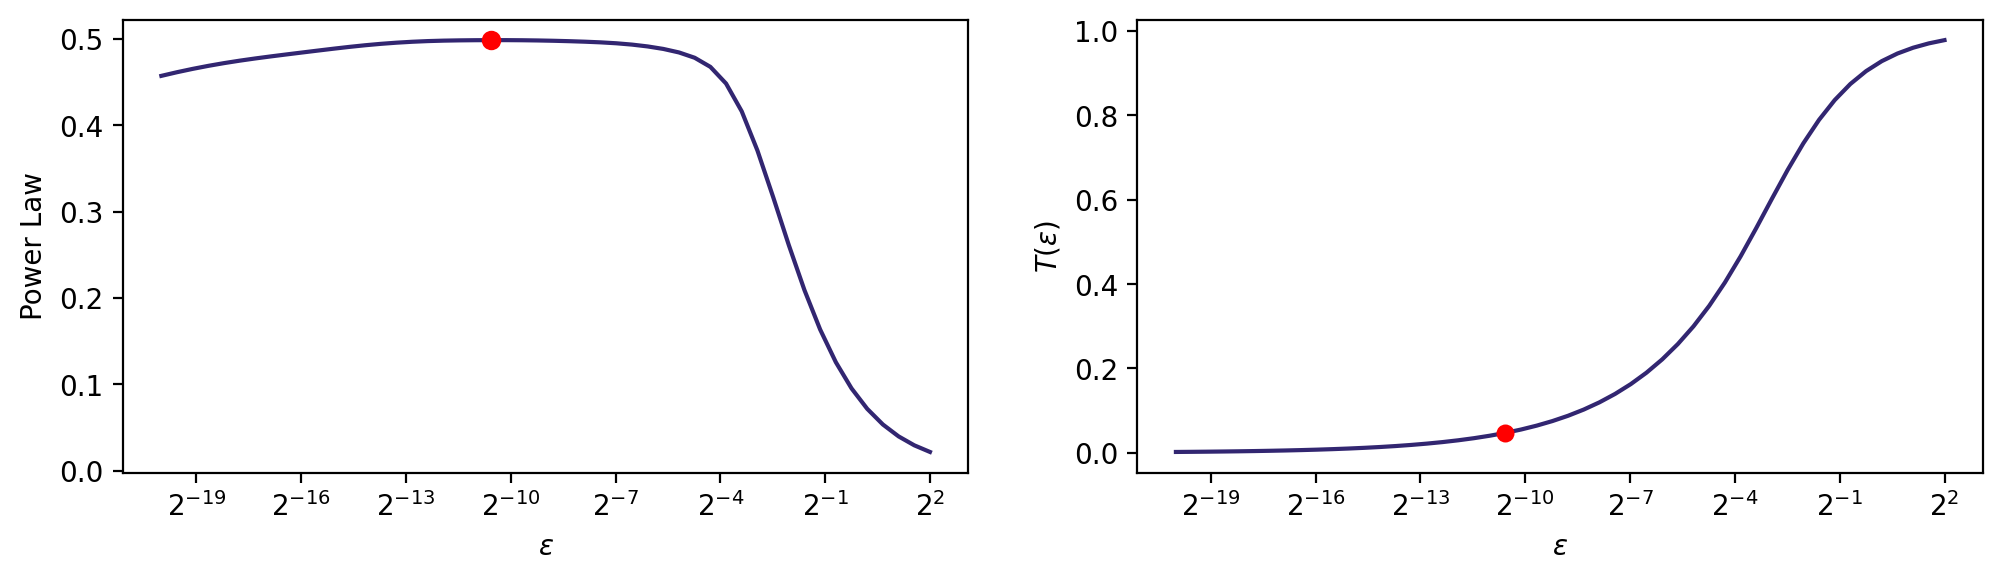

In [64]:
fig,axs = plt.subplots(1,2,figsize=(12,3),dpi=200)

axs[0].plot(2**np.linspace(-20,2),val,zorder=1,color='#322671')
axs[0].scatter(epsilon,max(val),color='red',zorder=2)

axs[0].set_xlabel('$\epsilon$')
axs[0].set_ylabel('Power Law')
axs[0].set_xscale('log',base=2)

axs[1].plot(2**np.linspace(-20,2), [T(2**l) for l in np.linspace(-20,2)],zorder=1,color='#322671')
axs[1].scatter(epsilon,T(epsilon),s=30,color='red',zorder=2)
axs[1].set_xlabel('$\epsilon$')
axs[1].set_ylabel('$T(\epsilon)$')
axs[1].set_xscale('log',base=2)

### 4. Compute the intrinsic dimension $d$ of the maifold $\mathcal{M}$ given by the data $\{x_i\}_{i=1}^{N}$, $d = 2\max_\epsilon \frac{\log(T(\epsilon + h) - \log(T(\epsilon))}{\log(\epsilon+h) - \log(\epsilon)}$

In [65]:
d = 2 * (log(T(h+epsilon)) - log(T(epsilon))) / (log(epsilon+h) - log(epsilon))
d

0.99680127760556

### 5. Compute the normalization kernel from the observations $$K_{\epsilon,\alpha}(x_i,x_j) = \frac{K_{\epsilon}(x_i,x_j)}{q_\epsilon(x_i)^\alpha q_\epsilon(x_j)^\alpha} $$ where $q_\epsilon(x) = \sum_{j=1}^N \frac{K_\epsilon(x,x_j)}{\rho(x)^d}$ and $\alpha = -d/4$

In [66]:
alpha = - d / 4
K_e = np.exp(Norm/epsilon)
q_e = (K_e.sum(axis=1) / (Rho ** d)).reshape(N,1)
K_e_a = K_e/((q_e**alpha)@ (q_e** alpha).T)

### 6. Construct a Markov matrix from $K_{\epsilon,\alpha}$ $$\hat{K}_{\epsilon,\alpha}(x_i,x_j) = \frac{K_{\epsilon,\alpha}(x_i,x_j)}{q_{\epsilon, \alpha}(x_i)}$$ where $q_{\epsilon, \alpha}(x)=\sum_{j=1}^{N} K_{\epsilon,\alpha}(x,x_j)$

In [67]:
K_e_a_hat = K_e_a/K_e_a.sum(axis=1)[:,None]

### 7. Compute the matrix estimation of $D^{-1}\mathcal{L}$, $L_\epsilon$ $$L_\epsilon(x_i,x_j) = \frac{\hat{K}_{\epsilon,\alpha}(x_i,x_j)-\delta_{ij}}{\epsilon \rho(x_i)^2} $$

In [68]:
q_e_a = K_e_a.sum(axis=1)

In [69]:
I = np.identity(N)
Dii = np.diag(q_e_a)
Pii = np.diag(Rho[0,:])
Sii = Pii @ np.sqrt(Dii)
S_1 = np.diag(1/np.diag(Sii))
L_hat = (1/epsilon) * (S_1 @ K_e_a @ S_1 - np.diag(1/(np.diag(Pii)**2)))
L_e = (1/epsilon) *np.diag(np.diag(Pii)**-2) @(np.diag(1/(np.diag(Dii))) @ K_e_a - I)

In [70]:
M = 1000
l, phi = sp.linalg.eigh(L_e,subset_by_index =(N-M,N-1),turbo=False)
l = l[::-1]
phi = phi[:,::-1]
phi = np.sqrt(N) * phi 

In [71]:
M = N
l, U = sp.linalg.eigh(L_hat,subset_by_index =(N-M,N-1),turbo=False)
l = l[::-1]
U = U[:,::-1]

In [72]:
phi = S_1 @ U
phi = phi / np.linalg.norm(phi,axis=0) * np.sqrt(N)

Text(0.5, 1.0, 'Eigenvectors')

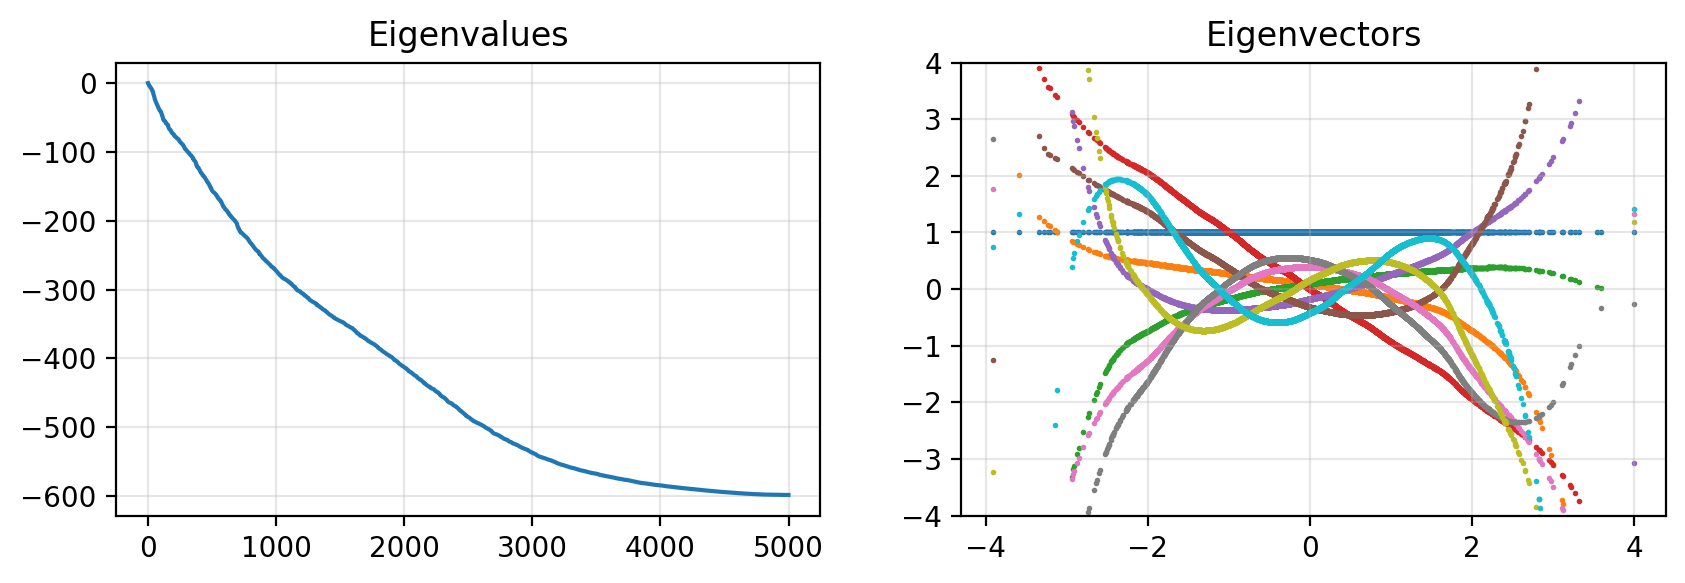

In [73]:
fig,axs = plt.subplots(1,2,figsize=(10,3),dpi=200)
axs[0].plot(l)
axs[0].set_title('Eigenvalues')
axs[0].grid(alpha=0.3)

for i in range(10):
    axs[1].scatter(X_s,phi[:,i],s=1)
axs[1].grid(alpha=0.3)
axs[1].set_ylim(-4,4)
axs[1].set_title('Eigenvectors')

### 8. Compute the eigenvalues and eigenvectors of $L_\epsilon$ to estimate the eigenvalues and eigenfunctions of $D^{-1}\mathcal{L}$: $\varphi_i,\lambda_i$. 

\begin{align}
\mathcal{L} & = D \Delta - \nabla U \cdot \nabla \\
& = D \Delta - x \cdot \nabla\\
\mathcal{L}\cos(x) &= -\cos(x) + x \sin(x)
\end{align}



$$\lambda_\ell = - (\ell -1),  \ \varphi_\ell (x) = \frac{1}{\sqrt{(\ell -1 )!}}H_{\ell - 1}(\sqrt{D^{-1}}x), \ \ell = 1,2,... $$

In [74]:
def Hermite(k,x,D):
    l_hermite = -(np.arange(0,k))
    phi_hermite = np.zeros((len(x),k))
    for ell in range(1,k+1):
        phi_hermite[:,ell-1] = (1/(factorial(ell-1)**0.5)) * eval_hermitenorm(ell-1,x*np.sqrt(1/D))
    return(l_hermite,phi_hermite)

l_hermite, phi_hermite =  Hermite(k=120,x=X_s,D=D)
L = phi_hermite @ np.diag(l_hermite) @ np.linalg.pinv(phi_hermite)

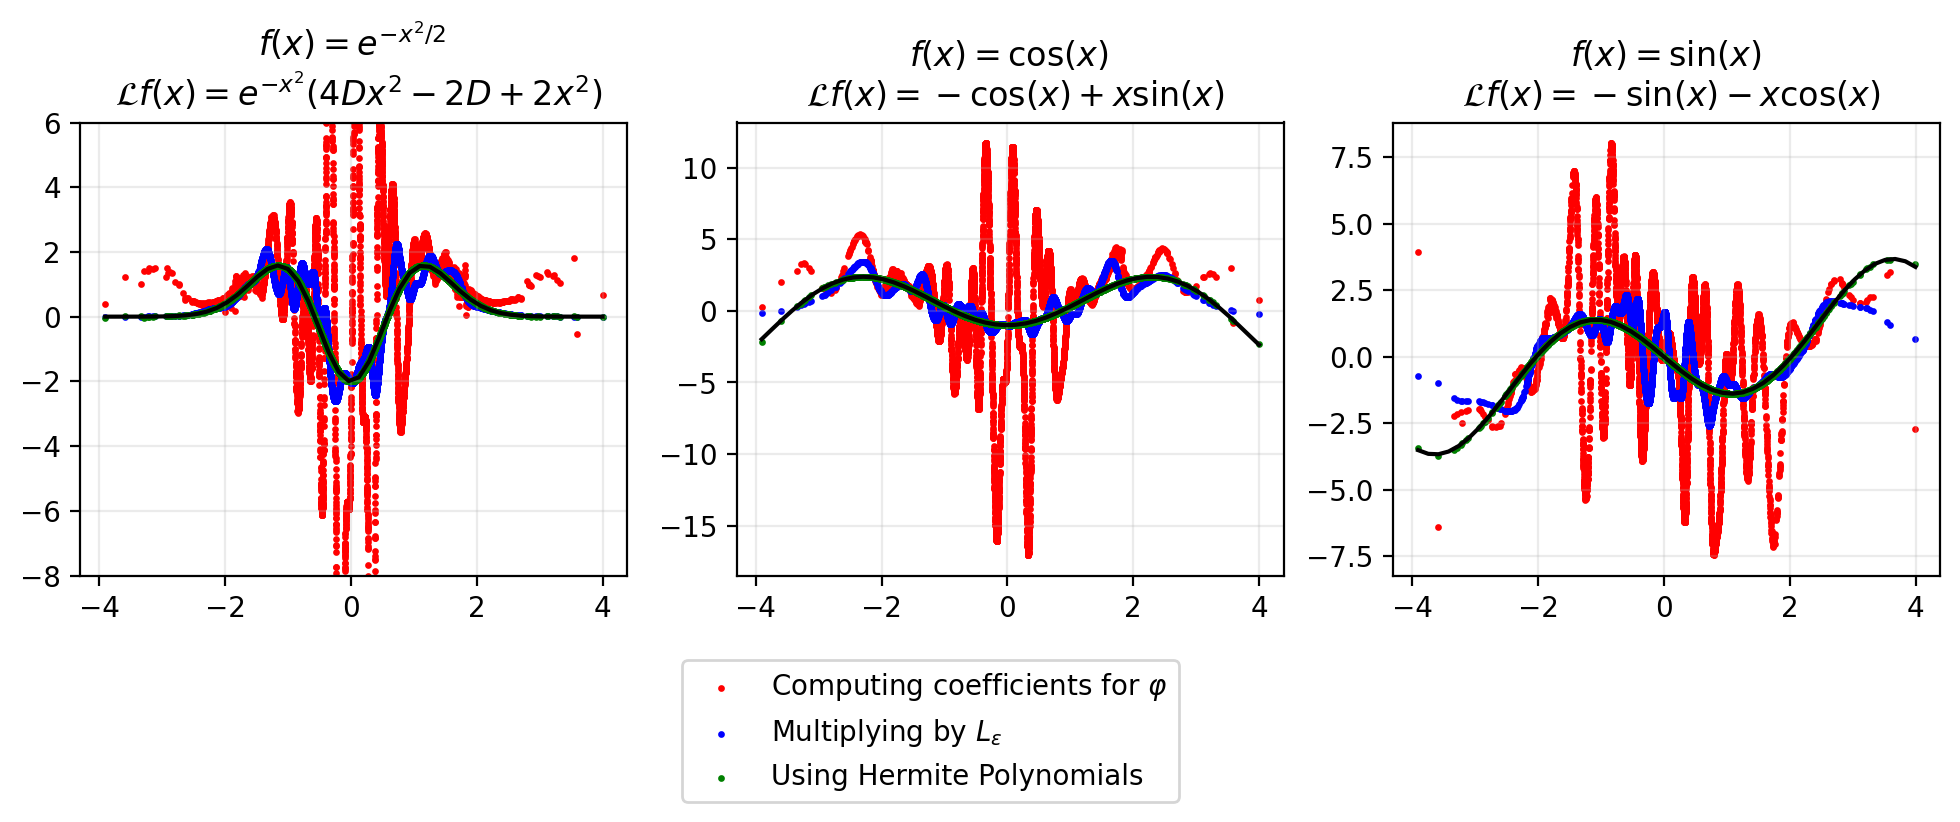

In [75]:
fig,axs = plt.subplots(1,3,figsize=(12,3),dpi=200)

x = np.linspace(min(X_s),max(X_s))

Y = np.exp(-X_s**2)
c_coef = (1/N) * (D*Y @ phi)
axs[0].set_title("$f(x) =e^{-x^2/2} $ \n $\mathcal{L}f(x) = e^{-x^2}(4Dx^2-2D + 2x^2) $")
axs[0].plot(x, D*np.exp(-x**2)*(4*x**2-2) + 2*x**2*np.exp(-x**2),color='k')
axs[0].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r')
axs[0].scatter(X_s,D*L_e@Y,s=2,color='b')
axs[0].scatter(X_s,L@Y,s=2,color='g')
axs[0].grid(alpha=0.25)
axs[0].set_ylim(-8,6)

Y = np.cos(X_s)
c_coef = (1/N) * (D*Y @ phi)

axs[1].set_title("$f(x) =\cos(x) $ \n $\mathcal{L}f(x) = -\cos(x)+x\sin(x) $")
axs[1].plot(x,-D*np.cos(x) + x * np.sin(x),color='k')
axs[1].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r')
axs[1].scatter(X_s,D*L_e@Y,s=2,color='b')
axs[1].scatter(X_s,L@Y,s=2,color='g')

axs[1].grid(alpha=0.25)

Y = np.sin(X_s)
c_coef = (1/N) * (D*Y @ phi)
axs[2].set_title("$f(x) =\sin(x) $ \n $\mathcal{L}f(x) = -\sin(x)-x\cos(x) $")
axs[2].plot(x,-D*np.sin(x) - x * np.cos(x),color='k')
axs[2].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r',label='Computing coefficients for $\\varphi$')
axs[2].scatter(X_s,D*L_e@Y,s=2,color='b',label='Multiplying by $L_{\epsilon}$')
axs[2].scatter(X_s,L@Y,s=2,color='g',label='Using Hermite Polynomials')

axs[2].grid(alpha=0.25)


axs[2].legend(loc=(-1.3,-0.5))

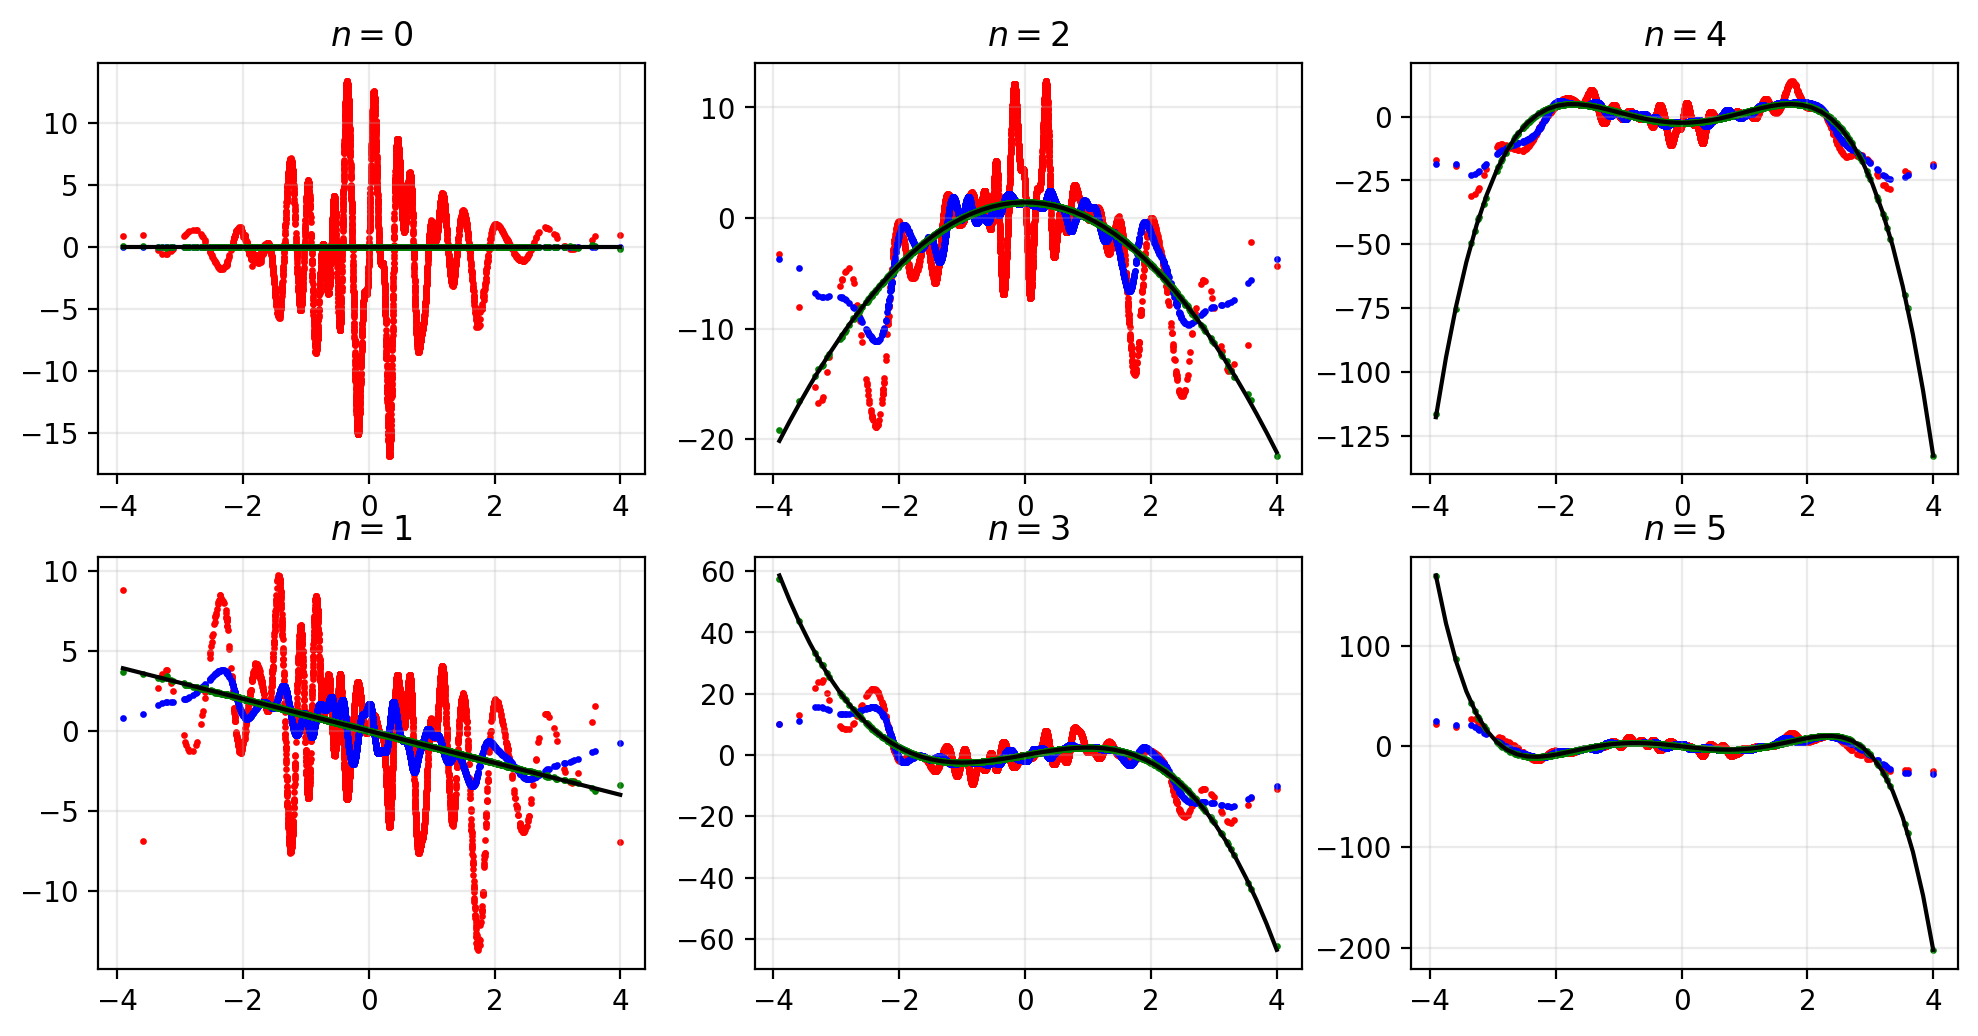

In [76]:
fig,axs = plt.subplots(2,3,figsize=(12,6),dpi=200)

for i,elle in enumerate([1,2,3,4,5,6]):
    Y = (1/(factorial(elle-1)**0.5)) * eval_hermitenorm(elle-1,X_s*np.sqrt(1/D))
    c_coef = (1/N) * (D*Y @ phi)
    x = np.linspace(min(X_s),max(X_s))
    
    axs[i%2,int(i / 2)].set_title(f"$n = {i}$")
    axs[i%2,int(i / 2)].plot(x,-(elle-1)*(1/(factorial(elle-1)**0.5)) * eval_hermitenorm(elle-1,x*np.sqrt(1/D)),color='k')
    axs[i%2,int(i / 2)].scatter(X_s,np.sum((c_coef*l) * phi,axis=1),s=2,color='r',label='Computing coefficients for $\\varphi$')
    axs[i%2,int(i / 2)].scatter(X_s,D*L_e@Y,s=2,color='b',label='Multiplying by $L_{\epsilon}$')
    axs[i%2,int(i / 2)].scatter(X_s,L@Y,s=2,color='g',label='Using Hermite Polynomials')
    axs[i%2,int(i / 2)].grid(alpha=0.25)

### 9. Compute a one dimensional observable $S$, for example $S(x(t)) = \sum_{i=1}^{n}((x(t))_i - \mathbb{E}((x(t))_i) $

In [ ]:
S = (X - X.mean()) / X.std()

### 10. Estimate the correlation time $$T_c = \int_{0}^{\infty} C(\tau)C(0)^{-1}d\tau \approx \text{(TR)}\int\frac{1}{T-j}\sum_{i=1}^{T-j}S(x_{i+j})S(x_i) $$

In [ ]:
T = n
height=[]
for j in range(1,T):
    inte = 1/(T-j)*sum(S[:T-j]*S[j:])
    if inte<0:
        break
    else:
        height.append(inte)
    
Tc = simps(x=np.linspace(0,n*dt,n)[:len(height)],y=height)

_ = plt.grid(alpha=0.35)
_ = plt.plot(np.linspace(0,n*dt,n)[:len(height)],height,color='k',lw=2)
_ = plt.fill_between(np.linspace(0,n*dt,n)[:len(height)],height,color='k',lw=2,alpha=0.2)
_ = plt.xlabel('$\\tau$')
_ = plt.title(f'$T_c = {Tc:.3f}$')

 ### 11. Estimate D as $$D = -\frac{1}{T_c}\frac{\sum_{i=1}^M \lambda_i ^{-1}(S(x)^{\top}\varphi_i)^2}{\sum_{i=1}^M (S(x)^{\top}\varphi_i)^2} $$

In [ ]:
S = (X_s - X_s.mean())
s1 = np.sum((1/l[1:]) * (S.T@phi[:,1:])**2)
s2 = np.sum((S.T@phi[:,1:])**2)
D = - (1/Tc)* (s1/s2)
D

# Push-forward of a initial density $p_0(x)$

### 1. Estimate the initial condition $c_i(0)$ as $$\hat{c}_i(0)=\frac{1}{N}\sum_{j=1}^N \frac{p_0(x_j)}{\hat{p}_{\text{eq}}(x_j)}\varphi_i(x_j) $$

In [ ]:
p_0 = np.vectorize(lambda x: (1/np.sqrt(2*pi))* np.exp((-(x-1)**2)/2) )
p_0 = np.vectorize(lambda x: sp.stats.norm.pdf(x,-2,0.3))
# p_0 = np.vectorize(lambda x: sp.stats.expon.pdf(x,1))

p_inf = np.vectorize(lambda x: (1/np.sqrt(2*pi))* np.exp((-(x)**2)/2) )
c_0 = (1/len(X_s)) * np.sum(((p_0(X_s)/rho_eq(X_s)))[:,None] * phi,axis=0)

### 2. Compute the numerical solution of the ODE $$\frac{\text{d} c}{\text{d} t} = D\Lambda c$$ with initial condition $\hat{c}_i(0)$

In [ ]:
Lambda = np.diag(l)
D = 1
def RHS(y,t):
    return((D*Lambda) @ y)

init = 0
tf = 5
Nt = 100
tarray = np.linspace(0,tf,Nt)

csol = odeint(RHS,c_0,tarray,args=())

### 3. Using $M$ modes estimate the density  as $$\hat{p}(x,t) =\hat{p}_{\text{eq}}(x) \sum_{i=0}^M \hat{c}_i(t)\varphi_i(x)$$

In [ ]:
_ = plt.figure(figsize=(7,4),dpi=100)
X_sort = np.sort(X_s)
N = len(X_s)
dx = np.diff(X_sort)
for t in [1,5,10,20,50,80,99]:
    est_density = np.zeros(N,)
    for i in range(N):
        est_density[i] = np.sum(csol[t] * phi[i,:] * rho_eq (X_s[i]))

    est_density=est_density[np.argsort(X_s)]
    cum = simps(x=X_sort,y= est_density)
    
    plt.plot(X_sort,(1/cum) *est_density,lw=1,color=plt.cm.plasma(t/100))
    
    
plt.plot(np.linspace(min(X_s),max(X_s),100),p_inf(np.linspace(min(X_s),max(X_s),100)),
         color='r',marker='x',ms=5,alpha=0.5)
plt.plot(np.linspace(min(X_s),max(X_s),100),p_0(np.linspace(min(X_s),max(X_s),100)),
         color='k',marker='x',ms=5,alpha=0.7)
    
plt.grid(alpha=0.3)

Approximation of the operator $\mathcal{L}^*$ using hermite polinomials

In [ ]:
N = 200
x = np.linspace(-3,3,N)
l_hermite_s, phi_hermite_s =  Hermite(k=20,x=x,D=D)
phi_hermite_s = p_invariant(x)[:,None] * phi_hermite_s
L_s = phi_hermite_s @ np.diag(l_hermite_s) @ np.linalg.pinv(phi_hermite_s)

In [ ]:
Y = np.exp(-x**2)
plt.scatter(x,L_s@Y,s=10,color='r')
plt.plot(x,np.exp(-x**2) + x*((-2*x)*np.exp(-x**2)) + (4*x**2-2)*np.exp(-x**2))


In [ ]:
def RHS(y,t):
    return(L_s @ y)

init = 0
tf = 5
Nt = 100
tarray = np.linspace(0,tf,Nt)

csol = odeint(RHS,p_0(x),tarray,args=())

In [ ]:
_ = plt.figure(figsize=(7,4),dpi=100)
for t in [0,1,5,10,20,50,80,99]:
    cum = simps(x=x,y= csol[t,:])

    _ = plt.plot(x,csol[t,:]/cum,color=plt.cm.plasma(t/100))
    
    
plt.plot(np.linspace(min(X_s),max(X_s),100),p_inf(np.linspace(min(X_s),max(X_s),100)),
         color='r',marker='x',ms=5,alpha=0.5)
plt.plot(np.linspace(min(X_s),max(X_s),100),p_0(np.linspace(min(X_s),max(X_s),100)),
         color='k',marker='x',ms=5,alpha=0.7)
plt.ylim(-0.1,1.6)
plt.grid(alpha=0.2)

Theoretical result
$$p(x,t) = \int \sqrt{\frac{1}{2\pi D(1-e^{-2t})}} \exp{\left(\frac{(x-x_0e^{-t})^2}{2D(1-e^{-2t}) } \right)}p_0(x_0)dx_0$$

In [ ]:
p_transition = lambda x0,x,t: sp.stats.norm.pdf(x,loc=x0*np.exp(-t),scale = 1-np.exp(-2*t))*p_0(x0)

In [ ]:
_ = plt.figure(figsize=(7,4),dpi=100)

for t in [0.1,0.5,1,2,5,10]:
    N = 100
    x = np.linspace(-3,3,N)
    x0 = np.linspace(-3,3,N)
    pxt = np.zeros_like(x)
    for i in range(N):
        pxt[i] = simps(x=x0,y=p_transition(x0,x[i],t))
    plt.plot(x,pxt)
    
    
plt.plot(np.linspace(min(X_s),max(X_s),100),p_inf(np.linspace(min(X_s),max(X_s),100)),
         color='r',marker='x',ms=5,alpha=0.5)
plt.plot(np.linspace(min(X_s),max(X_s),100),p_0(np.linspace(min(X_s),max(X_s),100)),
         color='k',marker='x',ms=5,alpha=0.7)
    
plt.grid(alpha=0.3)

# Push-forward of obserbable $f(x)$


In [ ]:
Lambda = np.diag(l)
D = 1
def RHS(y,t):
    return((D*Lambda) @ y)

init = 0
tf = 5
Nt = 100
tarray = np.linspace(0,tf,Nt)

csol = odeint(RHS,c_0,tarray,args=())

In [ ]:
for p in [1,2,3,4]:
    N = len(X_s)
    f = X_s**p
    a = (1/N)*(f @ phi)
    plt.plot(csol @ a)